In [1]:
from pysap.plugins.mri.reconstruct_3D.fourier import NUFFT, NFFT3, FFT3
import numpy as np
from pysap.plugins.mri.reconstruct_3D.utils import convert_mask_to_locations_3D

/home/bs255482/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@gmail.com>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

progressbar    : >=3.34.3  - required | 3.37.1    installed
future         : >=0.16.0  - required | 0.16.0    installed
astropy        : ==2.0.4   - required | 2.0.4     installed
pysparse       : >=0.0.1   - required | 0.0.1     installed
modopt         : >=1.1.4   - required | 1.1.5     installed
numpy          : >=1.11.0  - required | 1.14.3    installed
nibabel        : >=2.1.0   - required | 2.2.1     installed
scipy          : >=1.0.0   - required | 1.1.0     installed
pyqtgraph      : >=0.10.0  - re

In [2]:
_mask = np.ones(np.random.randint(2, size=(64,64,64)).shape)
_samples = convert_mask_to_locations_3D(_mask)
_samples_shift = convert_mask_to_locations_3D(np.fft.fftshift(_mask))
image = np.load('/volatile/bsarthou/datas/NUFFT/mri_img_2D.npy')
image = image[64:128, 64:128]
images = np.tile(image, (64,1,1))

In [3]:
fourier_op_dir_nufft = NUFFT(samples=_samples, platform='cpu', shape=(64,64,64), Kd=64, Jd=1)
fourier_op_dir_nfft = NFFT3(samples=_samples, shape=(64,64,64))

In [4]:
fourier_op_dir_fft = FFT3(samples=_samples_shift, shape=(64,64,64))

In [5]:
kspace_nfft = fourier_op_dir_nfft.op(images)
kspace_nufft = fourier_op_dir_nufft.op(images)
kspace_fft = np.fft.ifftshift(fourier_op_dir_fft.op(np.fft.fftshift(images)))
kspace_fft = kspace_fft.flatten()/np.sqrt(64*64*64)

(262144,)


In [6]:
print(kspace_nufft.shape)
print(kspace_nfft.shape)
print(kspace_fft.shape)

(262144,)
(262144,)
(262144,)


In [7]:
from modopt.math.metrics import mse

print(mse(kspace_nufft, kspace_nfft))
print(mse(kspace_nufft, kspace_fft))
print(mse(kspace_nfft, kspace_fft))

8.106368380727306e-22
8.1063685067369915e-22
3.140976778750038e-34


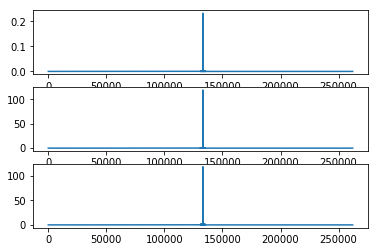

In [8]:
import matplotlib.pyplot as plt
plt.subplot(311)
plt.plot(np.abs(kspace_nufft))
plt.subplot(312)
plt.plot(np.abs(kspace_nfft))
plt.subplot(313)
plt.plot(np.abs(kspace_fft))

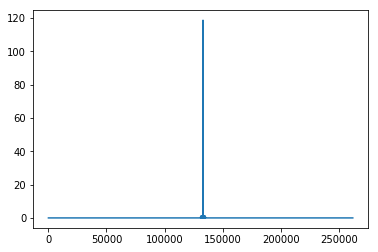

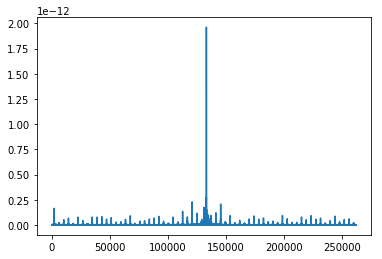

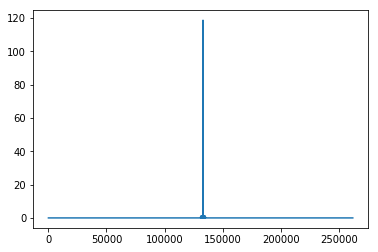

In [9]:
plt.figure()
plt.plot(np.abs(kspace_nufft - kspace_nfft))
plt.figure()
plt.plot(np.abs(kspace_nfft - kspace_fft))
plt.figure()
plt.plot(np.abs(kspace_nufft - kspace_fft))

In [10]:
non_z = np.nonzero(kspace_fft)
print(kspace_fft[non_z])
print(kspace_nfft[non_z])
print(kspace_nufft[non_z])

[-0.19558824+0.j         -0.12063134+0.35447572j  0.14082723-0.15084759j
 ... -0.34985852+0.46133301j  0.54347087-0.23776113j
 -0.00078517+0.02393312j]
[-0.19558824-6.73059404e-17j -0.12063134+3.54475718e-01j
  0.14082723-1.50847593e-01j ... -0.34985852+4.61333005e-01j
  0.54347087-2.37761127e-01j -0.00078517+2.39331218e-02j]
[-3.82008257e-04-2.99408121e-18j -2.35608167e-04+6.92335484e-04j
  2.75053246e-04-2.94624168e-04j ... -6.83317522e-04+9.01041020e-04j
  1.06146653e-03-4.64377196e-04j -1.53355068e-06+4.67442877e-05j]


In [11]:
kspace_input = np.copy(kspace_nfft)
fourier_op_adj_nufft = NUFFT(samples=_samples, platform='cpu', shape=(64,64,64), Kd=64, Jd=1)
fourier_op_adj_nfft = NFFT3(samples=_samples, shape=(64,64,64))
fourier_op_adj_fft = FFT3(samples=_samples_shift, shape=(64,64,64))


In [12]:
img_nfft = fourier_op_adj_nfft.adj_op(kspace_input)
img_nufft = fourier_op_adj_nufft.adj_op(kspace_input)
#kspace_fft = kspace_fft.flatten()/np.sqrt(64*64*64)
kspace_input_fft = np.reshape(kspace_input, (64,64,64))
img_fft = np.fft.fftshift(fourier_op_adj_fft.adj_op(np.fft.ifftshift(kspace_input_fft)))




In [13]:
print(mse(img_nufft, img_nfft))
print(mse(img_nufft, img_fft))
print(mse(img_nfft, img_fft))



6.964774085545097e-17
6.964777622837042e-17
6.355639685372634e-29


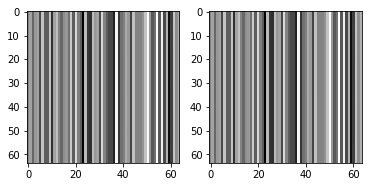

In [14]:
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(img_nfft[:,:,10]),cmap = 'gray')
plt.subplot(122)
plt.imshow(np.abs(img_fft[:,:,10]), cmap='gray')